In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.base import clone
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
seed = 5#1
np.random.seed(seed)

In [3]:
N = 100

# Attribute.
x = 6*np.random.rand(N, 1) - 3

# True function.
y = 2 + x + 0.5*x**2 

# Noise.
w = np.random.randn(N, 1)

# Observable function.
y_noisy = y + w

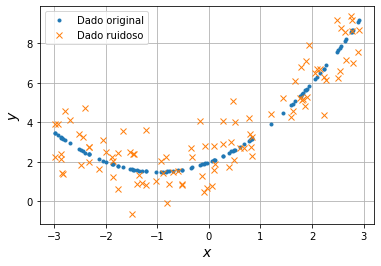

In [4]:
# Plot original data versus noisy version.
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()

#Show the plot.
plt.show()

### Define a ordem do modelo.

Percebam que a ordem é maior do que o número de amostras de treinamento. Portanto, o modelo irá sobreajustar.

In [5]:
model_order = 90

### Divisão do conjunto total de amostras em conjuntos de treinamento e validação.

In [6]:
X_train, X_val, y_train, y_val = train_test_split(x, y_noisy, test_size=0.3, random_state=seed)

print('Training set size:', len(y_train))
print('Validation set size:', len(y_val))

Training set size: 70
Validation set size: 30


### Padronização dos atributos.

In [7]:
poly_scaler = Pipeline([
    ("poly", PolynomialFeatures(degree=model_order, include_bias=True)),
    ("scaler", StandardScaler()),
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

### Treinamento do modelo.

**OBS**.: Observe que com `warm_start = True`, quando o método `fit()` é chamado, ele continua o treinamento de onde parou da última vez ao invés de reiniciá-lo do zero.

In [8]:
sgd_reg = SGDRegressor(max_iter=1,               # uma época.
                       tol=-np.infty,            # feito para que o treinamento não pare pelo critério de parada.
                       penalty=None,             # sem nenhuma regularização.
                       eta0=0.0005,              # passo de aprendizagem.
                       warm_start=True,          # continua o treinamento de onde parou da última vez ao invés de reiniciá-lo do zero.
                       learning_rate="constant", # passo de aprendizagem constante.
                       random_state=seed)

n_epochs = 2000
train_errors, val_errors = [], []
minimum_val_error = float("inf")
maximum_val_error = 0.0
best_epoch = None
best_model = None
for epoch in range(n_epochs):
    # Training.
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel())
    # Prediction.
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)    
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    # MSE.
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))
    # Early-stop.
    if val_errors[epoch] < minimum_val_error:
        minimum_val_error = val_errors[epoch]
        best_epoch = epoch
        best_model = clone(sgd_reg)
        y_train_pred_best_model = y_train_predict

### Resultados do treinamento.

Best epoch: 268


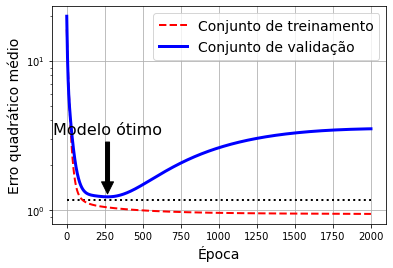

In [9]:
best_epoch = np.argmin(val_errors)
best_val_mse = val_errors[best_epoch]

print('Best epoch:', best_epoch)

plt.annotate('Modelo ótimo',
             xy=(best_epoch, best_val_mse),
             xytext=(best_epoch, best_val_mse + 2),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_mse -= 0.05  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_mse, best_val_mse], "k:", linewidth=2)
plt.plot(train_errors, "r--", linewidth=2, label="Conjunto de treinamento")
plt.plot(val_errors, "b-", linewidth=3, label="Conjunto de validação")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Época", fontsize=14)
plt.ylabel("Erro quadrático médio", fontsize=14)
plt.yscale('log')
plt.grid()
#plt.savefig("early_stoppingv3_error.png", dpi=600)

#Show the plot.
plt.show()

### Comparação dos resultados.

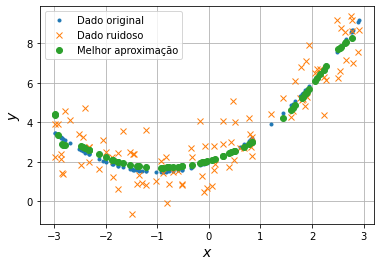

In [10]:
# Plot original data versus noisy version.
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(X_train, y_train_pred_best_model, 'o', label='Melhor aproximação')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("early_stoppingv3.png", dpi=600)

#Show the plot.
plt.show()

### Modelo sem regularização.

In [11]:
# Instantiate a polynomial with the given degree.
poly = PolynomialFeatures(degree=model_order, include_bias=True)
# Instantiate a scaler that will standardize the features.
scaler = StandardScaler()
# Instantiate a Lasso regressor.
reg = LinearRegression()
# Create a pipeline of actions.
model = Pipeline([
    ("poly", poly),
    ("scaler", scaler),
    ("reg", reg),
])

model.fit(X_train, y_train.ravel())

y_train_pred = model.predict(X_train)

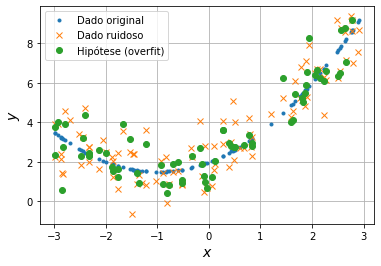

In [12]:
# Plot original data versus noisy version.
plt.plot(x, y, '.', label='Dado original')
plt.plot(x, y_noisy, 'x', label='Dado ruidoso')
plt.plot(X_train, y_train_pred, 'o', label='Hipótese (overfit)')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.legend()
plt.grid()
#plt.savefig("early_stoppingv3.png", dpi=600)

#Show the plot.
plt.show()